# SACOG Permit Data Analysis

Import Required Libraries

In [171]:
import pandas as pd
import requests
import json
import shapely
from shapely.geometry import Point, Polygon
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches
from IPython.display import Image
import seaborn as sns
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import plotly.express as px


/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/926947179.py:14: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/926947179.py:15: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Get Data from API for Tasks 1 and 2

In [140]:
#URL is the API endpoint for the query for the dataset. 
#This can be found using the supported 'query' operation for the dataset.
#Casting a wide net below to retrive everything from the dataset between 2010-2020 for EDA

url = "https://services.sacog.org/hosting/rest/services/Housing_Permit_Parcel_Points/FeatureServer/20/query"

# Function to get data from the API
def get_data():
    
    all_features = []
    result_offset = 0
    result_record_count = 1000
    
    while True:
        #MODIFY PARAMS BELOW AS NEEDED 
        #  AND GLUC4 <> 'DEMO' (Excludes DEMO GLUC4 Types)
        #
        params = {
            "where": "YEAR_ >= 2010 AND YEAR_ <= 2020",
            "outFields": "*",
            "outSR": "4326",
            "f": "json",
            "resultOffset": result_offset,
            "resultRecordCount": result_record_count,
        }

        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            features = json.loads(response.text)["features"]
            
            if not features:
                break
                
            all_features.extend(features)
            result_offset += result_record_count
        else:
            print(f"Error: {response.status_code}")
            break

    return all_features


In [141]:
#Taking the output of the above function and converting it to a dataframe for EDA

features = get_data()
def process_features(features):
    # Convert the list of dictionaries to a pandas DataFrame
    data_ = pd.DataFrame(features)

    # Extract the attributes and geometry data from the DataFrame
    data_attributes = pd.json_normalize(data_['attributes'])
    data_geo = pd.json_normalize(data_['geometry'])

    # Concatenate the attributes and geometry data into a single DataFrame
    data = pd.concat([data_attributes, data_geo], axis=1)

    return data
data = process_features(features)

In [117]:
#Dataframe for EDA

data.columns

Index(['OBJECTID', 'APN', 'LOT_SIZE', 'ZIP', 'FULL_ADD', 'UNITS', 'PERMITNUM',
       'SF_MF', 'QC', 'YEAR_', 'DENSITY', 'GLUC', 'GLUC4', 'REPORTING_',
       'ACCESSORY', 'FINAL_DATE', 'ISSUE_DATE', 'JURIS', 'ACRES', 'RangeCat',
       'UNITS_A', 'UNITS_SL', 'UNITS_LL', 'UNITS_RR', 'x', 'y', 'county'],
      dtype='object')

# Early Data Assessment (EDA)

In [ ]:
#pd.DataFrame(data.columns)

In [4]:
# Checking data integrity by seeing which columns have Null Counts and which don't.

# Create the null_counts dataframe
null_counts = pd.DataFrame(data.columns[data.isnull().any()], columns=['Columns with Null Values'])

# Create the no_null_counts dataframe
no_null_counts = pd.DataFrame(data.columns[data.notnull().all()], columns=['Columns with No Null Values'])

# Concatenate the dataframes horizontally with titles
combined_df = pd.concat([null_counts, no_null_counts], axis=1)

# Print the combined dataframe
pd.DataFrame(combined_df).fillna('-')


,Columns with Null Values,Columns with No Null Values
0,APN,OBJECTID
1,ZIP,LOT_SIZE
2,FULL_ADD,UNITS
3,PERMITNUM,SF_MF
4,QC,YEAR_
5,ACCESSORY,DENSITY
6,FINAL_DATE,GLUC
7,ISSUE_DATE,GLUC4
8,UNITS_A,REPORTING_
9,UNITS_SL,JURIS


In [5]:
# Group the data by APN and count the unique GLUC4 values
apn_gluc4_counts = data.groupby('APN')['GLUC4'].nunique()

# Filter the APNs with multiple unique GLUC4 values
apns_with_multiple_gluc4 = apn_gluc4_counts[apn_gluc4_counts > 1].index.tolist()

# Filter out blank or invalid APNs
valid_apns = data['APN'].str.replace('-', '').str.strip().str.upper()
valid_apns = valid_apns[~valid_apns.isin(['', '0'])]

# Filter the data to only include valid APNs with multiple GLUC4 values
filtered_data = data[data['APN'].isin(apns_with_multiple_gluc4) & valid_apns.isin(apns_with_multiple_gluc4)]

# Sort the filtered data by APN and YEAR_
sorted_data = filtered_data.sort_values(['APN', 'YEAR_'])

# Print the final DataFrame
data.query('GLUC4 != "DEMO" and APN == "00100900030000"')[['APN','YEAR_','GLUC4', 'UNITS', 'SF_MF', 'FULL_ADD']]

,APN,YEAR_,GLUC4,UNITS,SF_MF,FULL_ADD
41678,00100900030000,2019.0,RURAL RESIDENTIAL,1.0,SF,510 LOUISE ST
41707,00100900030000,2019.0,ATTACHED,2.0,MF24,1200 SITKA ST


In [6]:

# Filter the APNs with multiple unique GLUC4 values
apns_with_multiple_gluc4 = apn_gluc4_counts[apn_gluc4_counts > 1].index.tolist()

# Filter out blank or invalid APNs
valid_apns = data['APN'].str.replace('-', '').str.strip().str.upper()
valid_apns = valid_apns[~valid_apns.isin(['', '0'])]

# Filter the data to only include valid APNs with multiple GLUC4 values
filtered_data = data[data['APN'].isin(apns_with_multiple_gluc4) & valid_apns.isin(apns_with_multiple_gluc4)]

# Group the filtered data by APN and create a new column with the list of unique GLUC4 values
grouped_data = filtered_data.groupby('APN')['GLUC4'].apply(lambda x: sorted(x.unique())).reset_index(name='GLUC4')

# Count the number of permits for each APN
permit_counts = filtered_data.groupby('APN')['OBJECTID'].count().reset_index(name='PERMIT_COUNT')

# Merge the grouped data and permit counts into a single DataFrame
result_df = pd.merge(grouped_data, permit_counts, on='APN')

# Print the final DataFrame
pd.DataFrame(result_df)

,APN,GLUC4,PERMIT_COUNT
0,00100900030000,"[ATTACHED, DEMO, RURAL RESIDENTIAL]",91
1,00401910360000,"[DEMO, SINGLE FAMILY SMALL LOT]",3
2,00402420120000,"[DEMO, SINGLE FAMILY LARGE LOT]",2
3,00402440390000,"[DEMO, SINGLE FAMILY SMALL LOT]",2
4,00402840070000,"[DEMO, SINGLE FAMILY SMALL LOT]",2
...,...,...,...
242,9102005,"[DEMO, RURAL RESIDENTIAL]",2
243,9120026,"[DEMO, RURAL RESIDENTIAL]",2
244,9258005100,"[DEMO, RURAL RESIDENTIAL]",2
245,9416038,"[DEMO, RURAL RESIDENTIAL]",2


In [7]:
# Group the filtered data by APN and create a new column with the list of unique GLUC4 values
grouped_data = filtered_data.groupby('APN')['GLUC4'].apply(lambda x: sorted(x.unique())).reset_index(name='GLUC4')

# Get the sum of UNITS for each APN
units_sum = filtered_data.groupby('APN')['UNITS'].sum().reset_index(name='UNITS_SUM')

# Merge the grouped data and units sum into a single DataFrame
result_df = pd.merge(grouped_data, units_sum, on='APN')

# Print the final DataFrame
pd.DataFrame(result_df)


,APN,GLUC4,UNITS_SUM
0,00100900030000,"[ATTACHED, DEMO, RURAL RESIDENTIAL]",-205.0
1,00401910360000,"[DEMO, SINGLE FAMILY SMALL LOT]",-1.0
2,00402420120000,"[DEMO, SINGLE FAMILY LARGE LOT]",0.0
3,00402440390000,"[DEMO, SINGLE FAMILY SMALL LOT]",0.0
4,00402840070000,"[DEMO, SINGLE FAMILY SMALL LOT]",0.0
...,...,...,...
242,9102005,"[DEMO, RURAL RESIDENTIAL]",0.0
243,9120026,"[DEMO, RURAL RESIDENTIAL]",0.0
244,9258005100,"[DEMO, RURAL RESIDENTIAL]",0.0
245,9416038,"[DEMO, RURAL RESIDENTIAL]",0.0


In [ ]:
data.query('APN == "00101001" and YEAR_.between(2010, 2020)').copy()


In [ ]:
##test = data[data['FULL_ADD'] == '1278 ABROZO WY']
##test[['FULL_ADD','UNITS','FINAL_DATE', 'YEAR_', 'JURIS']]

Identifying Possible Unique Identifier

In [11]:
# Find duplicate PERMITNUM
duplicate_permits = data[data.duplicated(subset=['PERMITNUM'], keep=False)]

# Display the duplicate PERMITNUM
#pd.DataFrame(duplicate_permits)
#duplicate_permits

data_filtered = data.query('PERMITNUM == "185496"').copy()
data_filtered

,OBJECTID,APN,LOT_SIZE,ZIP,FULL_ADD,UNITS,PERMITNUM,SF_MF,QC,YEAR_,...,ISSUE_DATE,JURIS,ACRES,RangeCat,UNITS_A,UNITS_SL,UNITS_LL,UNITS_RR,x,y
80,4010,12309111100,22363.738755,95762,4141 GREENVIEW DR,1.0,185496,SF,C,2010.0,...,,EL DORADO COUNTY,0.513401,2008-2011,NaN,NaN,1.0,NaN,-121.058035,38.689192
37746,150969,723480031,6656.126870,None,3560 HERON DR,1.0,185496,SF,C,2019.0,...,None,FOLSOM,0.152804,2016-2019,NaN,NaN,1.0,NaN,-121.110552,38.625885


In [ ]:
# Count the number of unique values in each column
unique_values_count = data.nunique()

# Get the column names with all unique values
columns_with_all_unique_values = unique_values_count[unique_values_count == len(data)].index.tolist()

# Print the column names with all unique values
print(columns_with_all_unique_values)


  # Assumptions and Limitations

Based on the above cursory analysis, we can assume the following: 
    
    1) OBJECTID will serve as our identifier when we want a 'count'. 
    
    2) PERMITNUM is not a reliable identifier for permits for purposes of this cursory analysis. 
    There are too many missing and inconsistent values. There are also duplicate PermitNum values so it's not
    a 1:1 relationships. 
    
    3) GLUC4, UNITS, YEAR_, JURIS, SF_MF, x, and y can be used moving forward for this analysis since there are no
    blank values in these columns. 
        3a) x and y are geometric coordinates and will be used for question 3 (extra credit)
    
    4) According to the below link APN might be a good identifier but not enough of the APNs present meet the criteria
    of 14 digits. Noting it for potential future correction 
    https://assessor.saccounty.gov/FrequentlyAskedQuestions/Pages/ParcelMapFAQs.aspx
    
    5) It is unclear whether GLUC4 is a reliable attribute for housing type. For on thing, GLUC stands for General
    Land Use Code. Secondly, the available GLUC4 values are: 
        ATTACHED                   11208.0
        RURAL RESIDENTIAL           3565.0
        SINGLE FAMILY LARGE LOT    25232.0
        SINGLE FAMILY SMALL LOT    16805.0
    
    These GLUC4 titles have some that contain the word 'LOT' in them - which indicates they are more related to lot
    types. Additionally, there doesn't seem to be a reliable way to discern what housing type is losing units vs.
    gaining units based solely on the APN. 
    
    Finally, as we can see from the pivot below, there is no discernable way to determine the starting point for the
    the total units of GLUC4 numbers. Additionally based on the pivot below, ATTACHED GLUC4 is split between SF_MF of 
    MF5 and MF24. 
    
    SF_MF                     MF24    MF5       SF
    GLUC4                                         
    ATTACHED                 405.0  479.0      NaN
    DEMO                     174.0   13.0   1343.0
    RURAL RESIDENTIAL          NaN    NaN   3565.0
    SINGLE FAMILY LARGE LOT    NaN    NaN  25232.0
    SINGLE FAMILY SMALL LOT    NaN    NaN  16805.0

    This is a major assumption being made and is being used to justify the conclustion that SF_MF is the housing type
    - indicating Single Family/Multi Family units. GLUC4 is the General Land Use Code
    
    *https://www.sacog.org/post/urban-structure > Housing Permit Parcel Points 2001-2014 <- This link was also used to 
    reach this conclusion in researching this data. 

In [ ]:
#pivot_data = pd.pivot_table(data, index='GLUC4', columns='SF_MF', values='OBJECTID', aggfunc='count')
#
#pd.DataFrame(pivot_data)
#

# TASK 1

1) For each year (using the YEAR_ field) between 2010-2020: 
    
    a) Using the GLUC4 field, and excluding demolition permits (GLUC4 = “DEMO”), how many permits were solicited 
    for each housing type? 
    


In [12]:
#creating dataset for task 1

data_1a = data[['OBJECTID','YEAR_','UNITS', 'GLUC4', 'JURIS', 'SF_MF']]
data_1a['Housing_Type'] = data['SF_MF'].apply(lambda x: 'Multi Family' if 'MF' in x else 'Single Family')

/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/1602956262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1a['Housing_Type'] = data['SF_MF'].apply(lambda x: 'Multi Family' if 'MF' in x else 'Single Family')


In [15]:
##max_length = max(len(value) for value in data_1a.values)
##
### Pad the shorter arrays with missing values
##padded_data = {}
##for key, value in data_1a.items():
##    if len(value) < max_length:
##        padded_value = np.pad(value, (0, max_length - len(value)), mode='constant', constant_values='-')
##        padded_data[key] = padded_value
##    else:
##        padded_data[key] = value
##
### Create a DataFrame with the padded arrays
##padded_data_df = pd.DataFrame(padded_data)
##
### Get the unique values for each column
##unique_values = {
##    column: padded_data_df[column].unique()
##    for column in padded_data_df.columns
##}
##
### Convert each element of unique_values to a DataFrame and show it
##for column, values in unique_values.items():
##    column_df = pd.DataFrame({column: values})
##    print(f"\n{column}:\n{column_df}")
##

In [16]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Create a pivot table that groups the data by 'SF_MF' and displays the count of permits solicited for each year
result = pd.pivot_table(data_filtered, values='OBJECTID', index=['Housing_Type'], columns=['YEAR_'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total')

# Print the resulting pivot table

Q_1a = pd.DataFrame(result)
Q_1a

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
Housing_Type,,,,,,,,,,,,
Multi Family,89,59,46,79,71,49,72,104,80,160,75,884
Single Family,2505,1923,2662,3056,2825,4103,4376,5855,6681,6822,4794,45602
Total,2594,1982,2708,3135,2896,4152,4448,5959,6761,6982,4869,46486


In [17]:
Q1_a_summary_data = result.describe().astype(int)
Q1_a_summary_data

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
count,3,3,3,3,3,3,3,3,3,3,3,3
mean,1729,1321,1805,2090,1930,2768,2965,3972,4507,4654,3246,30990
std,1421,1093,1523,1742,1610,2354,2505,3350,3834,3893,2746,26076
min,89,59,46,79,71,49,72,104,80,160,75,884
25%,1297,991,1354,1567,1448,2076,2224,2979,3380,3491,2434,23243
50%,2505,1923,2662,3056,2825,4103,4376,5855,6681,6822,4794,45602
75%,2549,1952,2685,3095,2860,4127,4412,5907,6721,6902,4831,46044
max,2594,1982,2708,3135,2896,4152,4448,5959,6761,6982,4869,46486


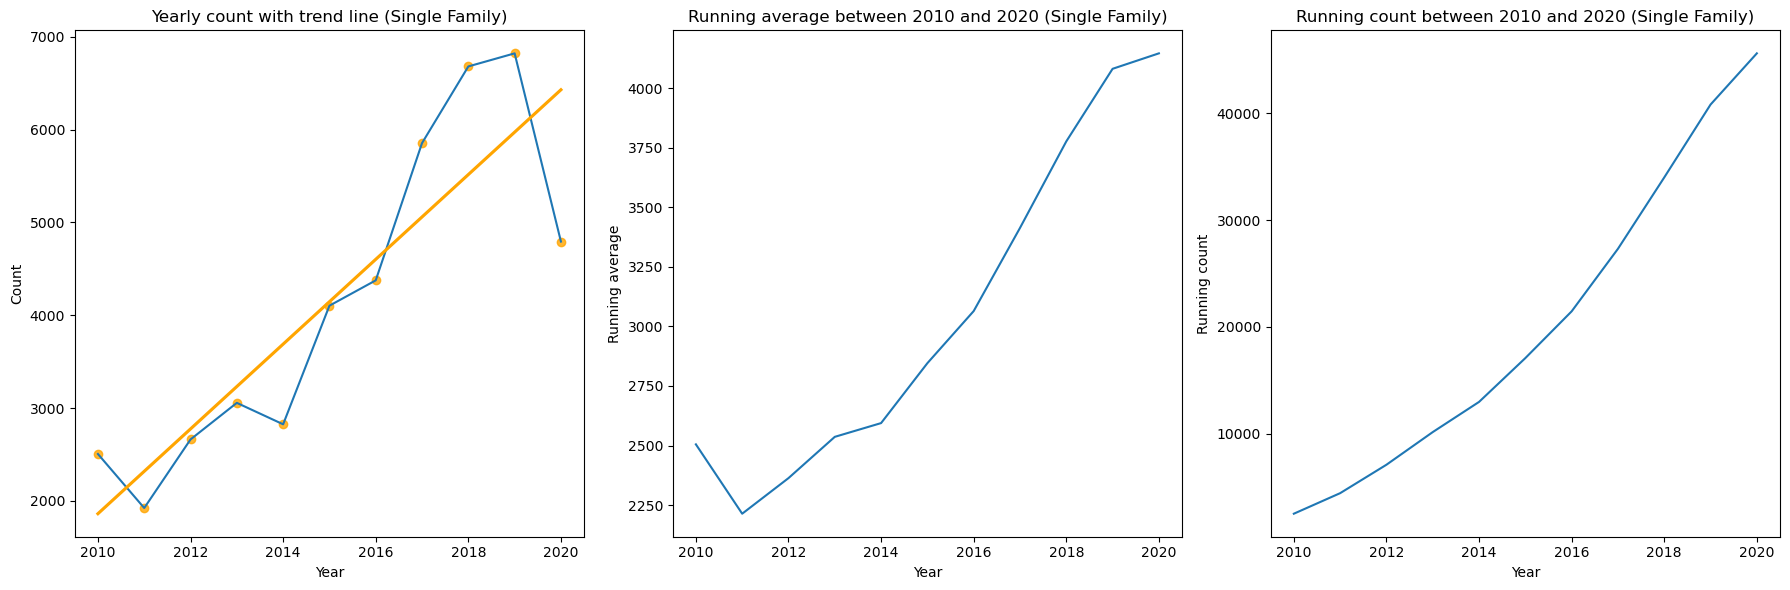

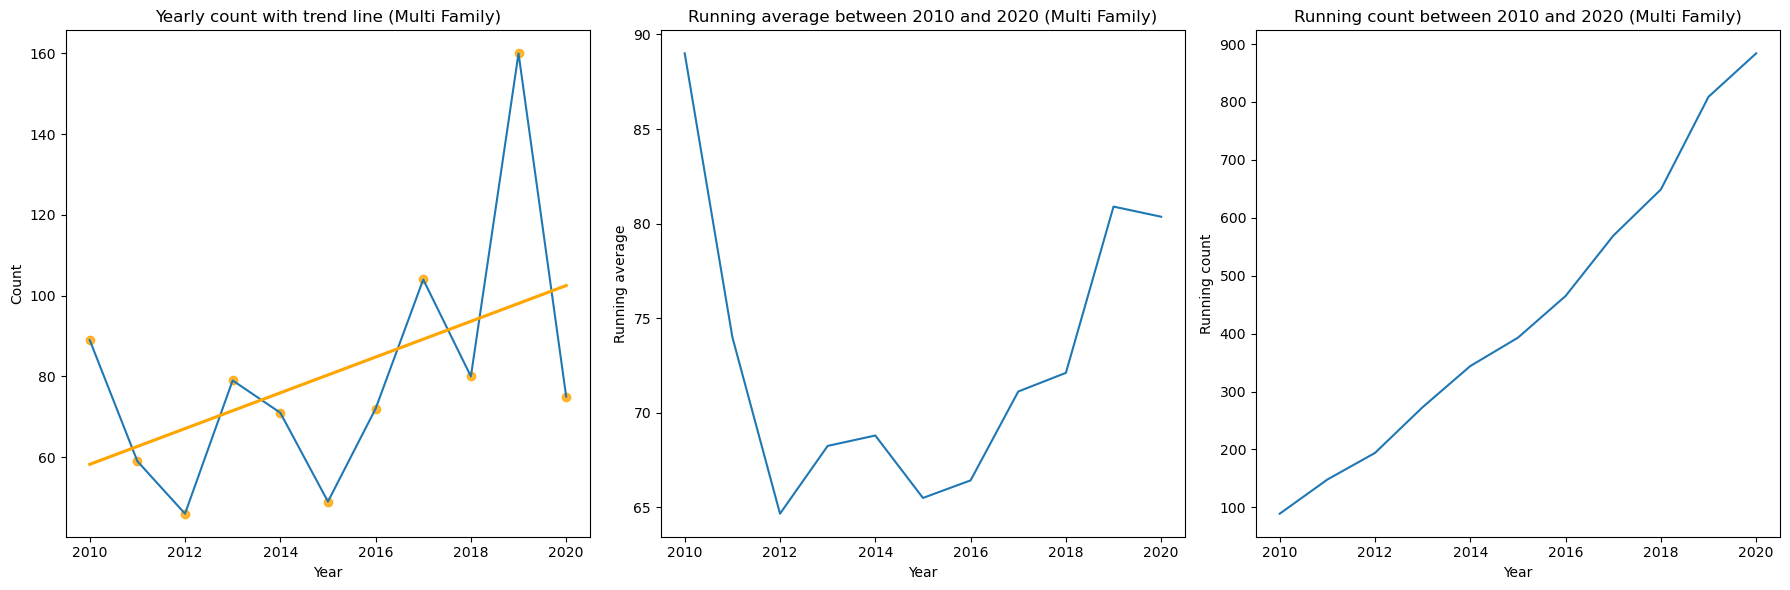

In [18]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Get the unique GLUC4 types
gluc4_types = data_filtered['Housing_Type'].unique()

# Create two subplots for each GLUC4 type
for gluc4 in gluc4_types:
    # Filter the DataFrame by GLUC4
    data_gluc4 = data_filtered[data_filtered['Housing_Type'] == gluc4]
    
    # Compute the yearly count, running count, and running average by year
    yearly_count = data_gluc4.groupby('YEAR_')['UNITS'].count()
    running_count = yearly_count.cumsum()
    running_average = running_count / np.arange(1, len(yearly_count) + 1)
    
    # Create the first subplot for yearly counts with a trend line
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.plot(yearly_count.index, yearly_count.values)
    sns.regplot(x=yearly_count.index, y=yearly_count.values, ax=ax1, ci=None, color='orange')
    ax1.set_title(f'Yearly count with trend line ({gluc4})')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Count')
    
    # Create the second subplot for running averages
    ax2.plot(running_average.index, running_average.values)
    ax2.set_title(f'Running average between 2010 and 2020 ({gluc4})')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Running average')
    
    # Create the third subplot for running totals
    ax3.plot(running_count.index, running_count.values)
    ax3.set_title(f'Running count between 2010 and 2020 ({gluc4})')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Running count')
    
    # Save the figure to a file
    fig.tight_layout()
    fig.savefig(f'{gluc4}.png')
    plt.show()


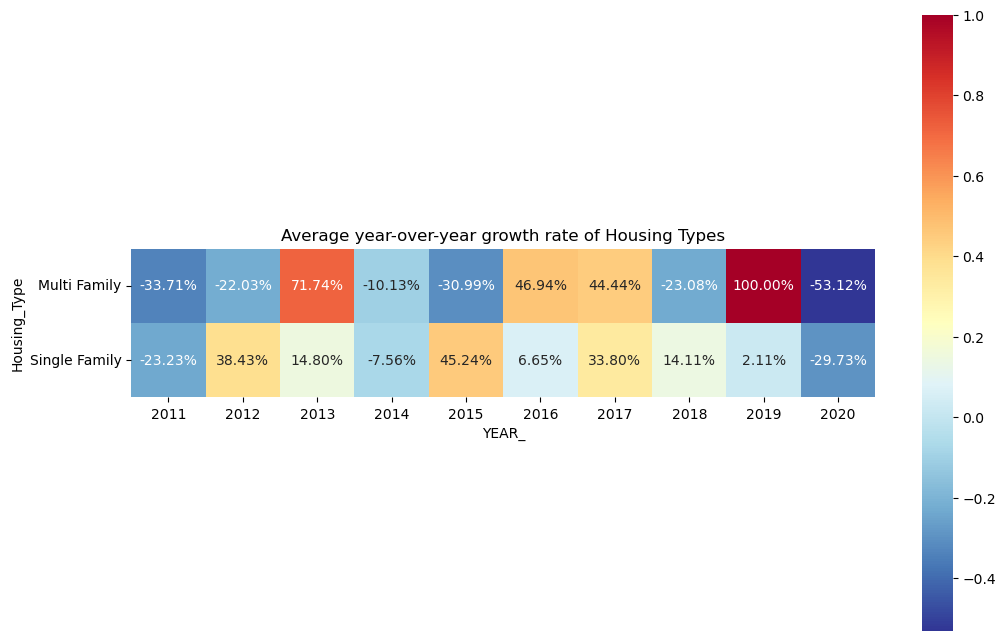

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert YEAR_ to integers
data_filtered['YEAR_'] = data_filtered['YEAR_'].astype(int)

# Group the data by GLUC4 and YEAR_ and compute the average number of permits
data_grouped = data_filtered.groupby(['Housing_Type', 'YEAR_'])['OBJECTID'].nunique().reset_index(name='count')
data_pivot = data_grouped.pivot(index='Housing_Type', columns='YEAR_', values='count')

# Compute the year-over-year growth rates for each GLUC4 type
growth_rates = data_pivot.pct_change(axis='columns').iloc[:, 1:]

# Create a heat map of the growth rates
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(growth_rates.astype(float), cmap='RdYlBu_r', annot=True, fmt='.2%', square=True, ax=ax)

# Set the x-tick labels to integers
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Set the plot title
plt.title('Average year-over-year growth rate of Housing Types')

# Display the plot
plt.show()


b) Using the GLUC4 field and UNITS field, and assuming all permits are approved and  constructed, how many net units will be built for each housing type (i.e., new units net of  units that are removed through demolition)? 

*Assumption: SF_MF is the housing type - indicating Single Family/Multi Family units. GLUC4 is likely the permit type. This assumption was reached by reading this web page: 

*https://www.sacog.org/post/urban-structure > Housing Permit Parcel Points 2001-2014

In [30]:
#creating dataset for task 1

data_1b = data[['OBJECTID','YEAR_','UNITS', 'GLUC4', 'JURIS', 'SF_MF']]
data_1b['YEAR_'] = data_1b['YEAR_'].astype(int)
data_1b['Housing_Type'] = data['SF_MF'].apply(lambda x: 'Multi Family' if 'MF' in x else 'Single Family')

/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/2271549806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1b['YEAR_'] = data_1b['YEAR_'].astype(int)
/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/2271549806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1b['Housing_Type'] = data['SF_MF'].apply(lambda x: 'Multi Family' if 'MF' in x else 'Single Family')


In [34]:
# Convert UNITS column to numeric data type
data_1b['UNITS'] = pd.to_numeric(data_1b['UNITS'], errors='coerce')

# Pivot by sum of UNITS for each Housing_Type
Q1_b = data_1b.pivot_table(values='UNITS', index='Housing_Type', columns='YEAR_', aggfunc='sum', margins=True, margins_name='Total')

Q1_b.astype(int)


/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/1502491525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1b['UNITS'] = pd.to_numeric(data_1b['UNITS'], errors='coerce')


YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
Housing_Type,,,,,,,,,,,,
Multi Family,719,709,867,981,525,666,903,950,1123,1437,1678,10558
Single Family,2371,1774,2511,2910,2690,3973,4285,5740,6529,6682,4794,44259
Total,3090,2483,3378,3891,3215,4639,5188,6690,7652,8119,6472,54817


In [35]:
Q1_b_summary_data = Q1_b.describe().astype(int)
Q1_b_summary_data

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
count,3,3,3,3,3,3,3,3,3,3,3,3
mean,2060,1655,2252,2594,2143,3092,3458,4460,5101,5412,4314,36544
std,1215,892,1275,1480,1425,2127,2258,3076,3490,3517,2432,23115
min,719,709,867,981,525,666,903,950,1123,1437,1678,10558
25%,1545,1241,1689,1945,1607,2319,2594,3345,3826,4059,3236,27408
50%,2371,1774,2511,2910,2690,3973,4285,5740,6529,6682,4794,44259
75%,2730,2128,2944,3400,2952,4306,4736,6215,7090,7400,5633,49538
max,3090,2483,3378,3891,3215,4639,5188,6690,7652,8119,6472,54817


# Question 2

Using the GLUC4, UNITS, and JURIS fields, how many net housing units (net of demolitions) did each  jurisdiction approve between 2010 and 2020? 

Assumption: The sum of the UNITS field should suffice for this analysis as the a unit recorded as demolished is not 
likely to have been recorded as demolished if not approved.


In [100]:
# Create a new DataFrame with JURIS, UNITS, and DEMO_UNITS columns
juris_data = data[['YEAR_','JURIS', 'UNITS', 'x','y']].copy()
juris_data['DEMO_UNITS'] = data['UNITS'].where(data['GLUC4'] == 'DEMO', 0)

# Group by JURIS and sum the UNITS and DEMO_UNITS values
grouped_data = juris_data.groupby('JURIS').agg({'UNITS': 'sum', 'DEMO_UNITS': 'sum'})

# Calculate the NET_UNITS by subtracting the DEMO_UNITS from the UNITS
grouped_data['NET_UNITS'] = grouped_data['UNITS'] - grouped_data['DEMO_UNITS']

# Add a row with the totals for all JURIS
totals_row = pd.Series(grouped_data.sum(), name='Total')
grouped_data_table = grouped_data.append(totals_row)

grouped_data_table

/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_13644/3287333907.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grouped_data_table = grouped_data.append(totals_row)


,UNITS,DEMO_UNITS,NET_UNITS
JURIS,,,
AUBURN,290.0,-6.0,296.0
CITRUS HEIGHTS,95.0,-93.0,188.0
COLFAX,0.0,-4.0,4.0
DAVIS,1021.0,-33.0,1054.0
EL DORADO COUNTY,3619.0,-289.0,3908.0
ELK GROVE,5744.0,-18.0,5762.0
FOLSOM,3660.0,-23.0,3683.0
GALT,501.0,-14.0,515.0
ISLETON,11.0,0.0,11.0


In [192]:
# Create a new DataFrame with JURIS, UNITS, and DEMO_UNITS columns
juris_data = data[['YEAR_','JURIS', 'UNITS', 'x','y']].copy()
juris_data['DEMO_UNITS'] = data['UNITS'].where(data['GLUC4'] == 'DEMO', 0)

# Group by JURIS and YEAR_ and sum the UNITS and DEMO_UNITS values
grouped_data = juris_data.groupby(['JURIS', 'YEAR_']).agg({'UNITS': 'sum', 'DEMO_UNITS': 'sum'})

# Calculate the NET_UNITS by subtracting the DEMO_UNITS from the UNITS
grouped_data['NET_UNITS'] = grouped_data['UNITS'] - grouped_data['DEMO_UNITS']

# Reset the index to move JURIS to its own column and create a separate index for YEAR_
grouped_data = grouped_data.reset_index()

grouped_data.columns


Index(['JURIS', 'YEAR_', 'UNITS', 'DEMO_UNITS', 'NET_UNITS'], dtype='object')

In [201]:
import plotly.express as px

# Create a new DataFrame with JURIS, UNITS, and DEMO_UNITS columns
juris_data = data[['YEAR_','JURIS', 'UNITS', 'x','y']].copy()
juris_data['DEMO_UNITS'] = data['UNITS'].where(data['GLUC4'] == 'DEMO', 0)

# Group by JURIS and YEAR_ and sum the UNITS and DEMO_UNITS values
grouped_data = juris_data.groupby(['JURIS', 'YEAR_']).agg({'UNITS': 'sum', 'DEMO_UNITS': 'sum'})

# Calculate the NET_UNITS by subtracting the DEMO_UNITS from the UNITS
grouped_data['NET_UNITS'] = grouped_data['UNITS'] - grouped_data['DEMO_UNITS']

# Reset the index to move JURIS to its own column and create a separate index for YEAR_
grouped_data = grouped_data.reset_index()

# Sort the data by year
grouped_data = grouped_data.sort_values('YEAR_', ascending=True)

# Create a treemap with Plotly Express
fig = px.treemap(grouped_data, 
                 path=['YEAR_', 'JURIS'],
                 values='NET_UNITS',
                 color='JURIS')

fig.show()


# Task 3: 
**Extra credit – Using the API for SACOG’s counties (shown below), figure out which county each  permit was issued in and show how many permits were issued in each county between 2010-2020.

In [142]:
import requests
import json

# make a request to the URL and get the JSON data
url = 'https://services6.arcgis.com/YBp5dUuxCMd8W1EI/arcgis/rest/services/Counties/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(url)
json_data = json.loads(response.text)

# create a dictionary to store the outermost points for each county
county_dict = {}

# loop through each feature and find the outermost points
for feature in json_data['features']:
    county_name = feature['attributes']['COUNTY_NAM']
    county_boundaries = feature['geometry']['rings']

    # initialize variables to store the outermost points
    min_lon = float('inf')
    max_lon = float('-inf')
    min_lat = float('inf')
    max_lat = float('-inf')

    # loop through each ring and find the outermost points
    for ring in county_boundaries:
        for point in ring:
            lon, lat = point
            if lon < min_lon:
                min_lon = lon
            if lon > max_lon:
                max_lon = lon
            if lat < min_lat:
                min_lat = lat
            if lat > max_lat:
                max_lat = lat

    # add the outermost points to the dictionary for the county
    county_dict[county_name] = ((min_lon, min_lat), (max_lon, max_lat))

county_dict

{'Yuba': ((-121.636094303965, 38.9183987915514),
  (-121.009489129948, 39.6396072262018)),
 'Placer': ((-121.484452101151, 38.71137435993),
  (-120.002476017499, 39.3164500245933)),
 'Sutter': ((-121.948303982183, 38.734582714418),
  (-121.414487160201, 39.3054593369948)),
 'El Dorado': ((-121.148990937667, 38.5024286556686),
  (-119.877261864068, 39.0674885483529)),
 'Yolo': ((-122.422062990819, 38.3130418079634),
  (-121.501104946819, 38.9260358212458)),
 'Sacramento': ((-121.863078097369, 38.0181385611437),
  (-121.022533170032, 38.7359524284132))}

In [143]:
# Add a new column to the data DataFrame to store the county for each permit
data['county'] = ''

# Loop through each permit and find the county it is in
for index, row in data.iterrows():
    permit_location = Point(row['x'], row['y'])
    found_county = False
    
    # Check if the permit is within a county polygon
    for county_name, county_points in county_dict.items():
        (min_lon, min_lat), (max_lon, max_lat) = county_points
        if row['x'] >= min_lon and row['x'] <= max_lon and row['y'] >= min_lat and row['y'] <= max_lat:
            data.at[index, 'county'] = county_name
            found_county = True
            break
    
    # Print a warning message if the permit is not within any county
    if not found_county:
        print(f"Warning: Permit {row['PERMITNUM']} not within any county.")


,PERMITNUM,county
0,198726,El Dorado
1,227315,El Dorado
2,176025,El Dorado
3,216823,El Dorado
4,196022,El Dorado
...,...,...
48011,BLD20-00206,Yuba
48012,BLD19-02243,Yuba
48013,BLD19-02249,Yuba
48014,BLD19-02187,Yuba


In [149]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data.query('YEAR_.between(2010, 2020) and ISSUE_DATE.notnull()').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

#Group data by county and year for pivot
result = pd.pivot_table(data_filtered, values='OBJECTID', index=['county'], columns=['YEAR_'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total')
# Print the resulting pivot table
result = result.fillna(0)
pd.DataFrame(result).astype(int)


YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2019,2020,Total
county,,,,,,,,,,,
El Dorado,156,107,213,412,473,482,141,779,0,310,3073
Placer,1087,850,1188,1023,1094,1633,1782,2095,867,682,12301
Sacramento,955,797,1063,1365,960,1590,1396,1729,1894,660,12409
Sutter,68,58,22,29,45,60,47,27,2,50,408
Yolo,272,176,231,308,254,289,882,1231,1125,183,4951
Yuba,211,159,148,146,252,229,296,217,0,509,2167
Total,2749,2147,2865,3283,3078,4283,4544,6078,3888,2394,35309


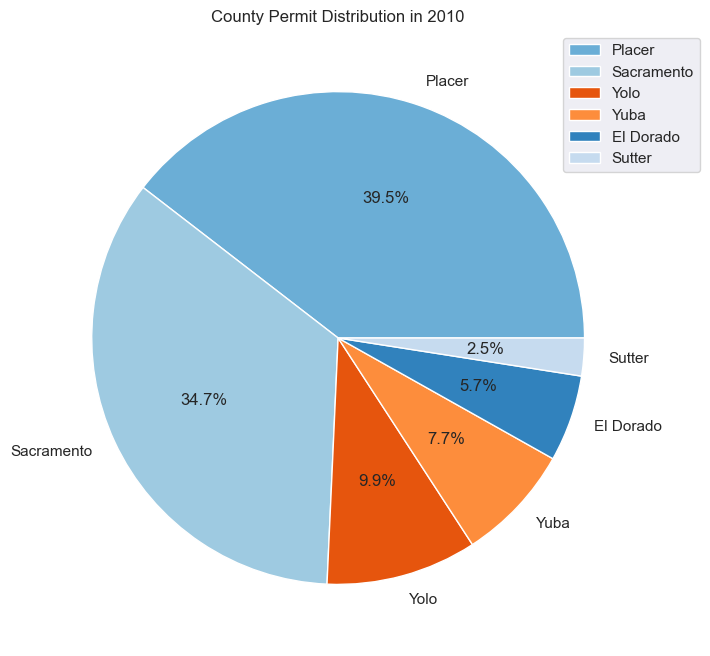

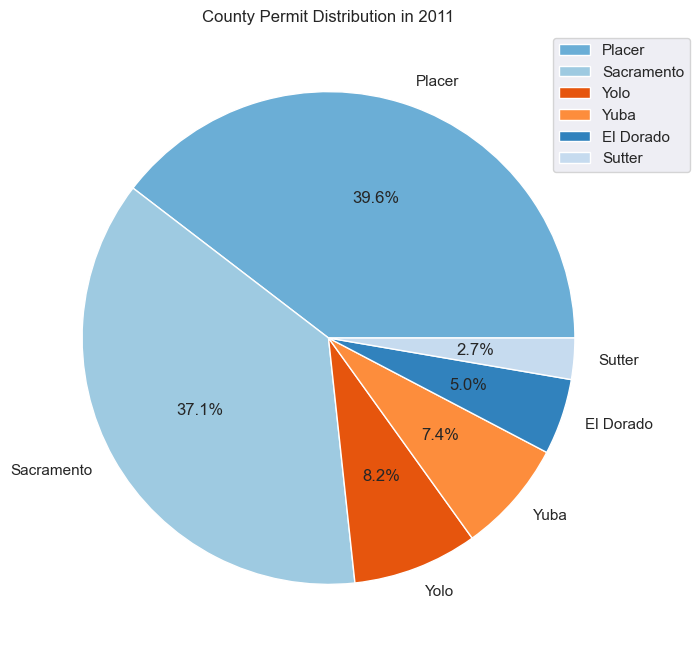

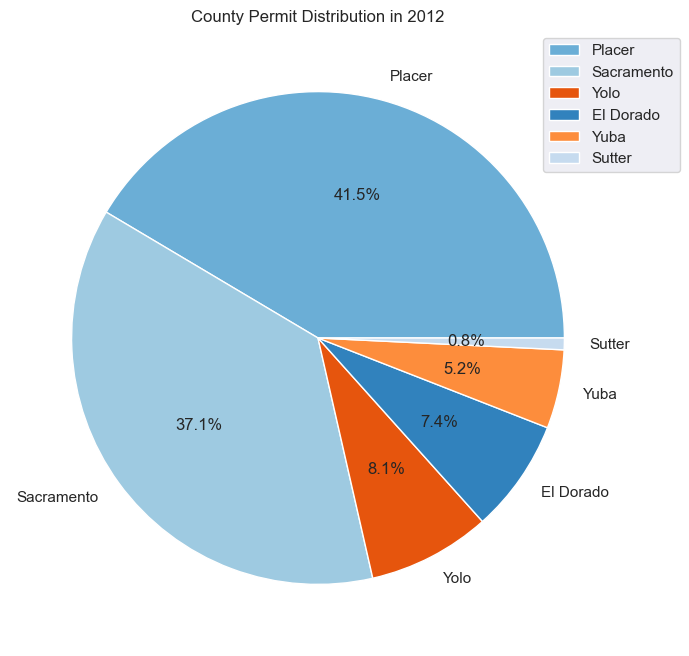

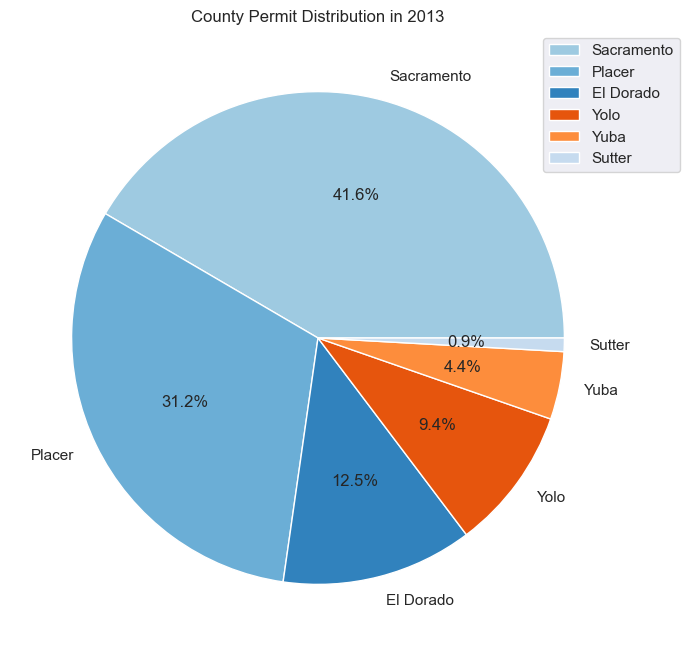

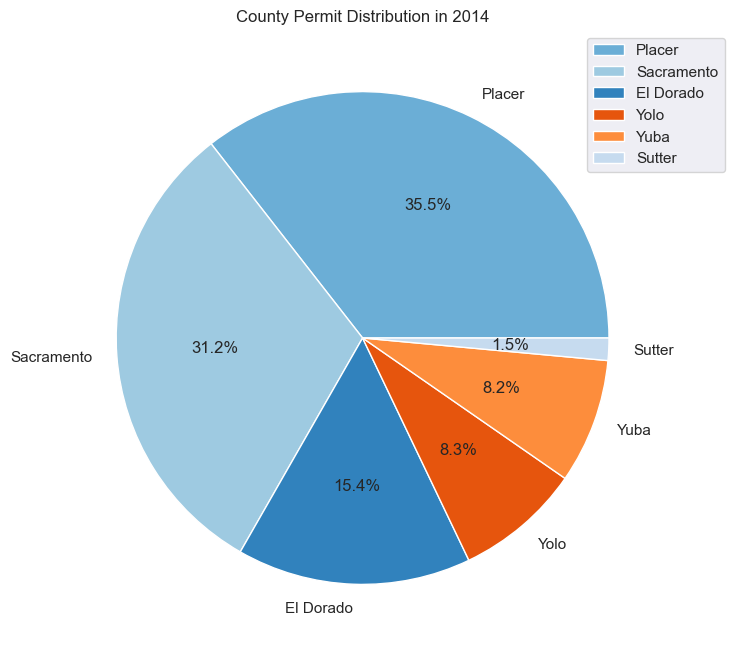

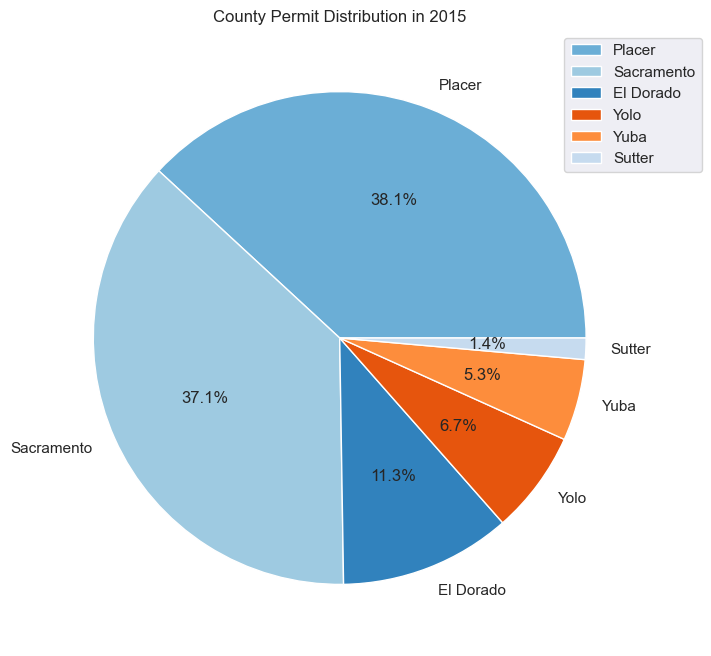

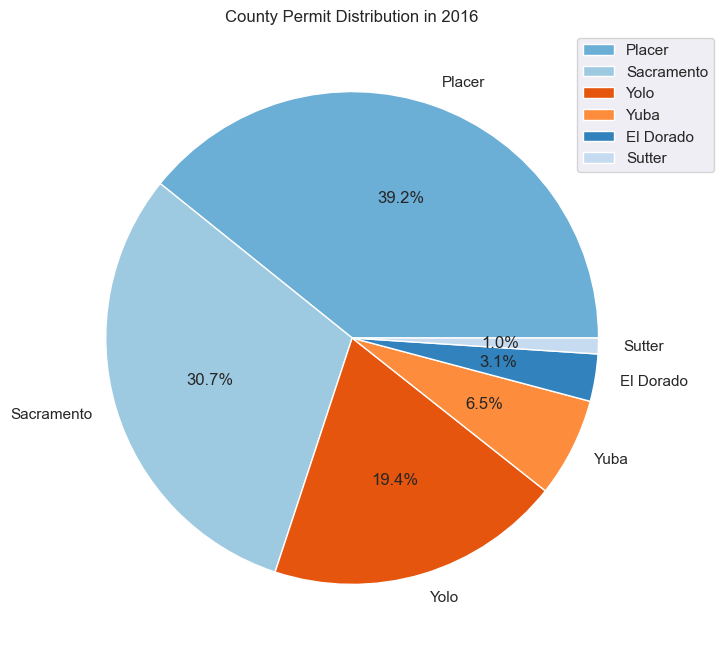

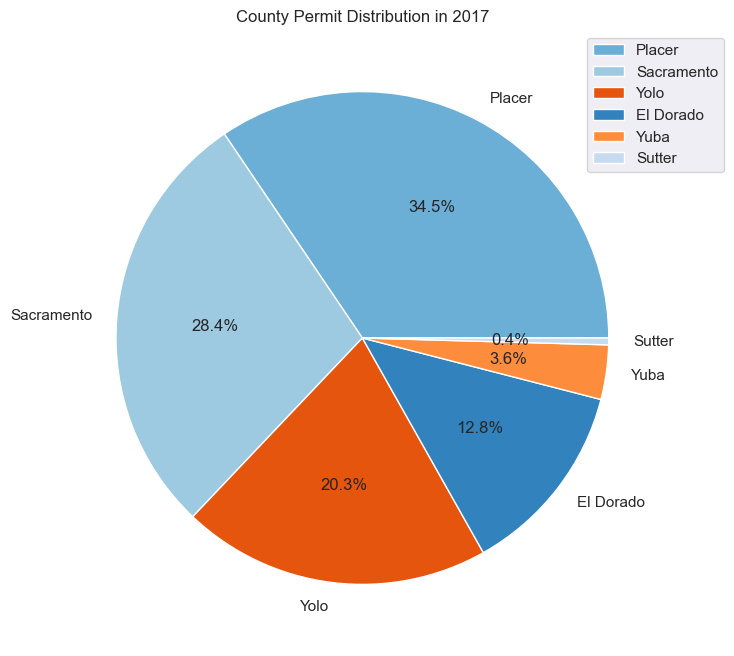

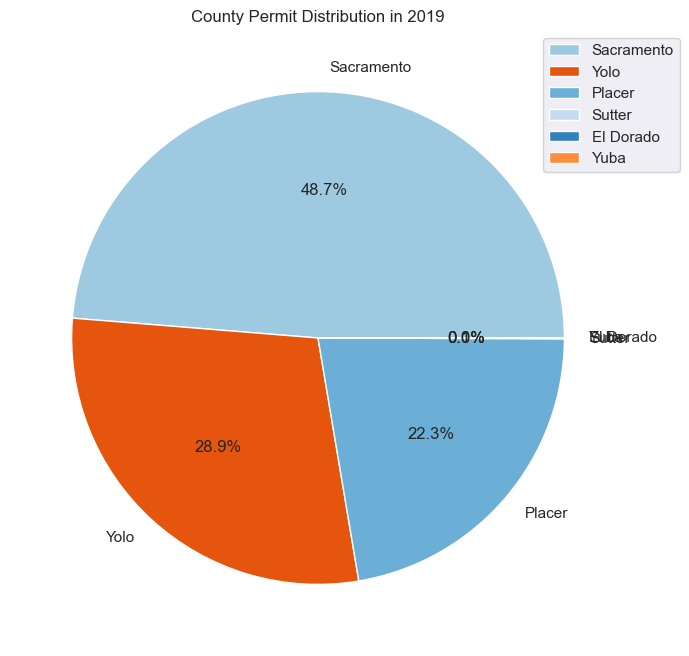

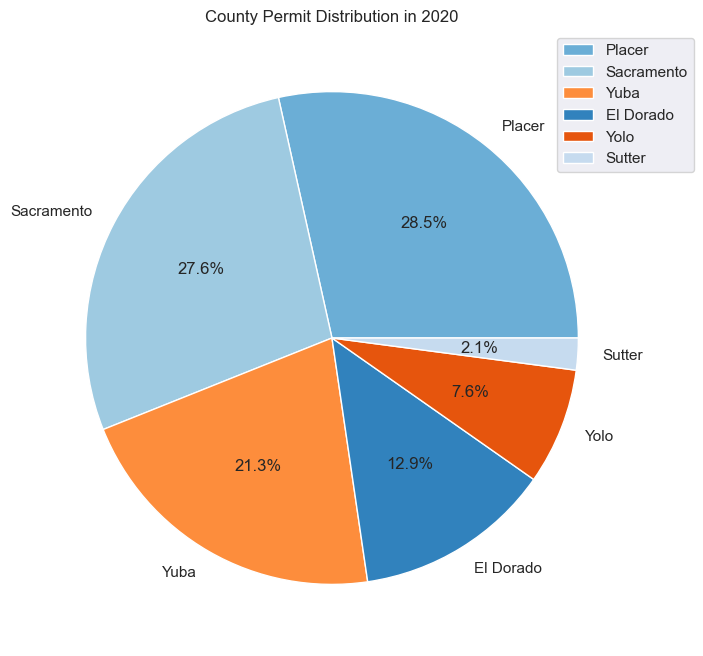

In [153]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data.query('YEAR_.between(2010, 2020) and ISSUE_DATE.notnull()').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Group data by county and year for pivot
result = pd.pivot_table(data_filtered, values='OBJECTID', index=['county'], columns=['YEAR_'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total')

# Fill in missing values with zeros and exclude 'Total' row and column
result = result.fillna(0).drop('Total')
result = result.drop('Total', axis=1)

# Define color palette and dictionary to keep colors consistent across years
colors = sns.color_palette('tab20c')
color_dict = dict(zip(result.index, colors))

# Loop through each year and create a pie chart
for year in result.columns:
    year_data = result[year].sort_values(ascending=False).iloc[:10]
    
    county_colors = [color_dict[county] for county in year_data.index]
    plt.figure(figsize=(8, 8))
    plt.pie(year_data, labels=year_data.index, autopct='%1.1f%%', colors=county_colors)
    plt.title(f'County Permit Distribution in {year}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.show()


<Figure size 1200x600 with 0 Axes>

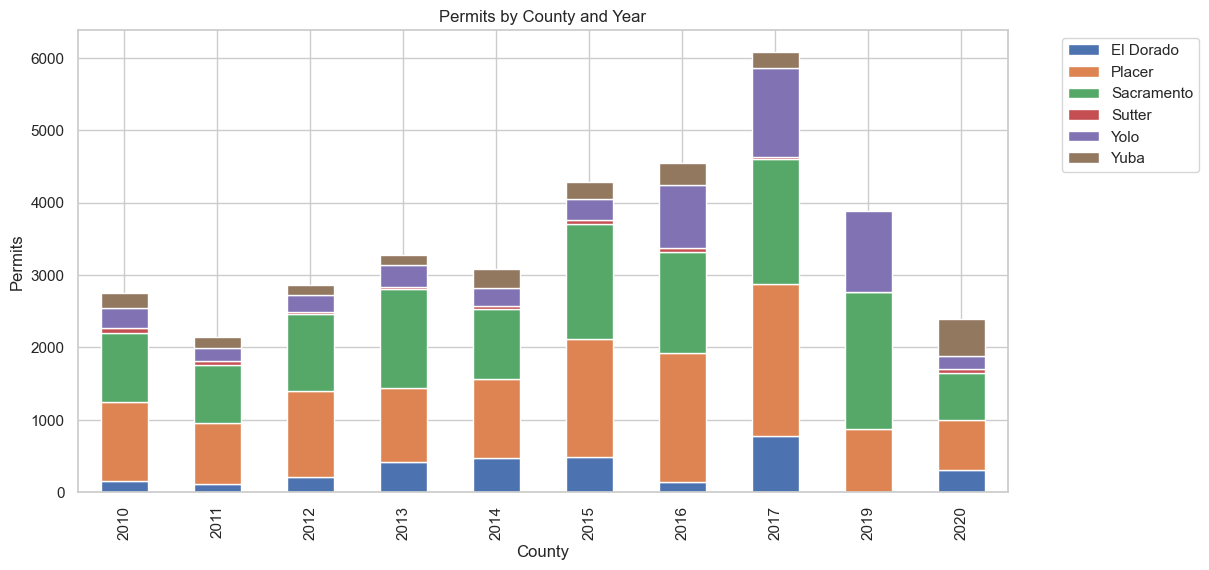

In [168]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data.query('YEAR_.between(2010, 2020) and ISSUE_DATE.notnull()').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Group data by county and year for pivot
result = pd.pivot_table(data_filtered, values='OBJECTID', index=['YEAR_'], columns=['county'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total')

# Fill in missing values with zeros and drop the 'Total' column
result = result.fillna(0).drop('Total', axis=1)

# Drop the row for 'Total'
result = result.drop('Total')

# Create the stacked bar chart
plt.figure(figsize=(12, 6))
result.plot(kind='bar', stacked=True)
plt.xlabel('County')
plt.ylabel('Permits')
plt.title('Permits by County and Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Recommendations:


Based on the analysis above, I would provide the following recommendations:

1. Focus on increasing affordable housing: The analysis shows that the majority of permits are for single-family housing types, which tend to be more expensive. It is important to encourage the development of more affordable housing types, such as multi-family housing, to accommodate diverse income groups and address housing affordability challenges in the region.


2. Encourage higher-density development: To maximize land use efficiency and reduce urban sprawl, it is important to promote higher-density housing types, such as multi-family and mixed-use developments. This can be achieved through zoning changes, incentives, and public-private partnerships.


3. Streamline the permitting process: Reducing the time and cost associated with obtaining permits can encourage more housing development and help meet the increasing demand for housing in the region. Streamlining the permitting process can include measures such as simplifying zoning codes, digitizing the permit application process, and providing more resources for planning departments.


4. Monitor demolition trends: The analysis shows that there are some demolitions happening, leading to a net decrease in housing units. It is important to monitor these trends and identify the reasons for demolitions, whether it is due to deteriorating housing stock, land use changes, or other factors. This information can help inform policies to minimize unnecessary loss of housing units.


5. Collaborate with jurisdictions: The analysis shows that the number of net housing units approved varies by jurisdiction. It is essential to collaborate with individual jurisdictions to identify local challenges and opportunities in housing development and work together to create policies and programs that support the regional housing goals.




